# **PREPROCESSING**

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Step 1: Load the CSV file into a DataFrame
file_path = 'supermarket_dataset.csv'
df = pd.read_csv(file_path)

# Step 2: Combine Date and Time into a single DateTime column
# Ensure Date is in datetime format and combine with Time
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Handle parsing issues gracefully
df['Time'] = df['Time'].astype(str)  # Ensure Time is string type
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], errors='coerce')
df.drop(columns=['Date', 'Time'], inplace=True)

# Step 3: Handle missing values by replacing with zero (basic imputation)
df.fillna(0, inplace=True)

# Step 4: Encode categorical variables using LabelEncoder
# Target columns are encoded; others are excluded for interpretability
label_encoders = {}
categorical_columns = ['Customer type', 'Gender', 'Payment']  # Specify target columns
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for potential future use

# Step 5: Extract additional temporal features from DateTime
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour'] = df['DateTime'].dt.hour

# Step 6: Compute additional metrics
# RevenuePerUnit: Represents revenue for each unit sold
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
# TotalTaxAmount: Assumes a fixed tax percentage of 5%
df['TotalTaxAmount'] = df['Total'] * 0.05
# IsWeekend: Identifies if a transaction occurred on a weekend
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df.drop(columns=['DateTime'], inplace=True)  # Remove DateTime column if no longer needed

# Step 7: Apply log transformation to handle skewness
for col in ['Quantity', 'Total', 'gross income']:
    log_col = f'Log{col.capitalize()}'
    df[log_col] = np.log1p(df[col])  # Log transform with np.log1p to handle zero values

# Step 8: Feature interaction - Quantity multiplied by Unit Price
df['QuantityUnitPrice'] = df['Quantity'] * df['Unit price']

# Step 9: Outlier removal using Interquartile Range (IQR) method for Total
Q1 = df['Total'].quantile(0.25)
Q3 = df['Total'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Total'] >= Q1 - 1.5 * IQR) & (df['Total'] <= Q3 + 1.5 * IQR)]

# Step 10: Scale numerical features for uniformity
numerical_features = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'gross income', 'Rating']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Step 11: Save the cleaned and processed data to a new CSV file
output_file = 'processed_sales_data.csv'
df.to_csv(output_file, index=False)

print(f"Data preprocessing completed successfully. Saved to '{output_file}'.")


# **VISUALIZATION**

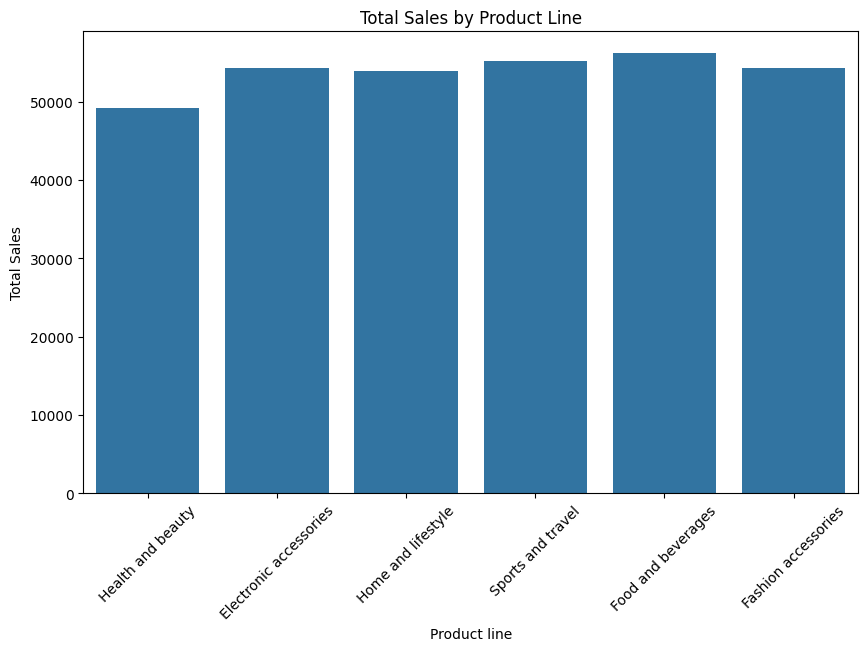

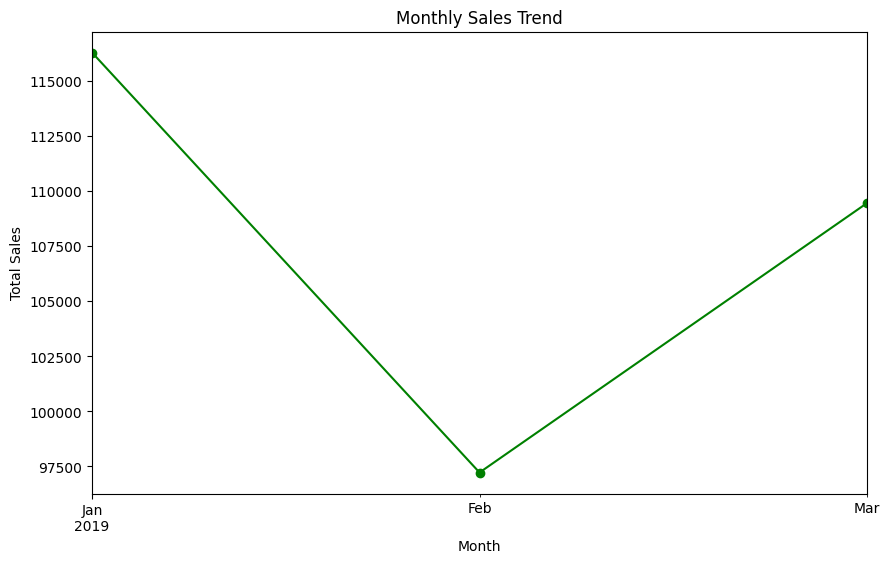

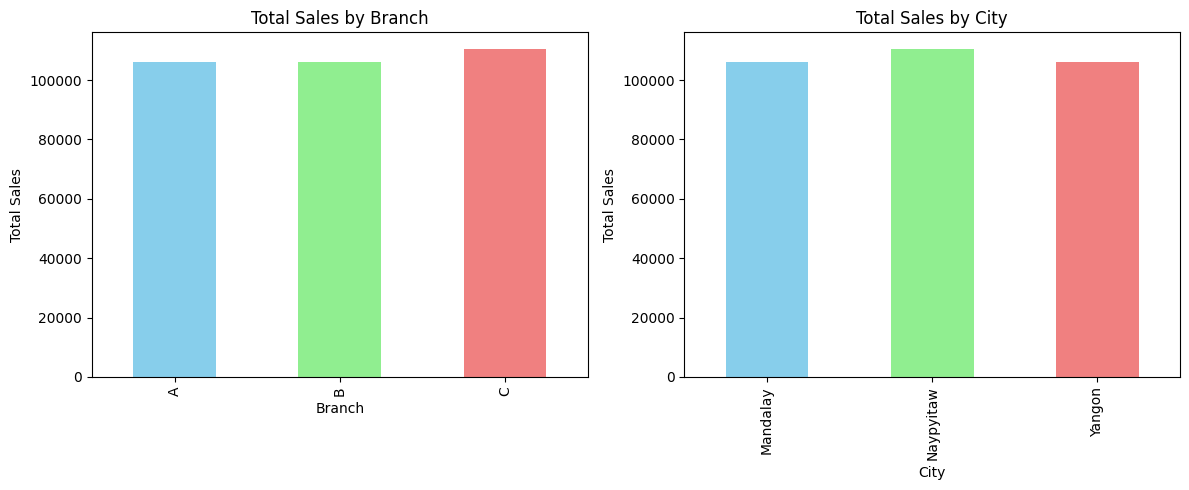

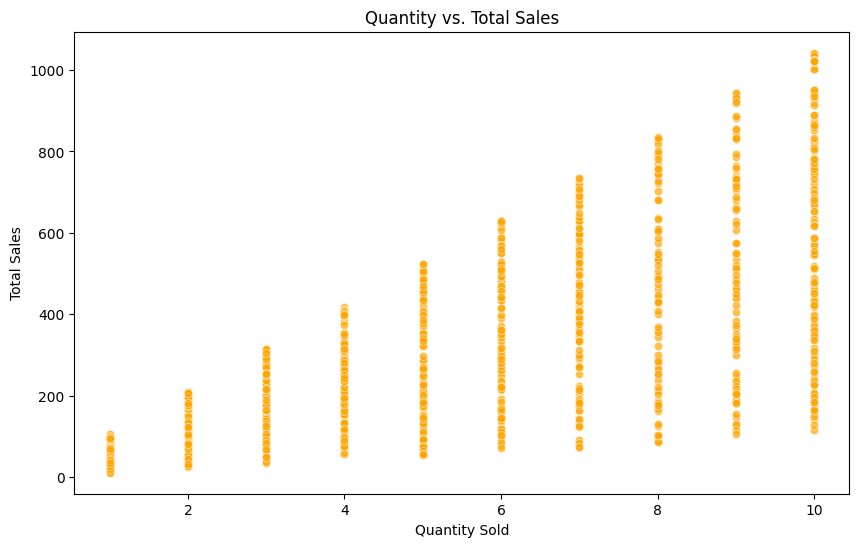

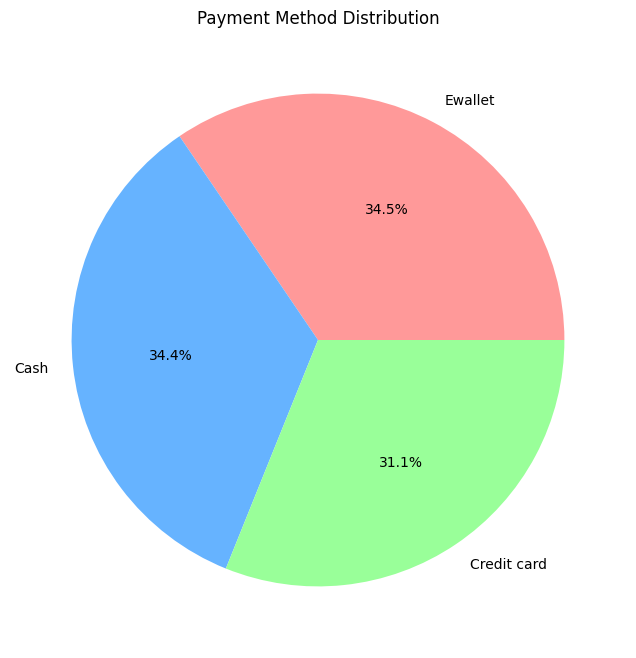

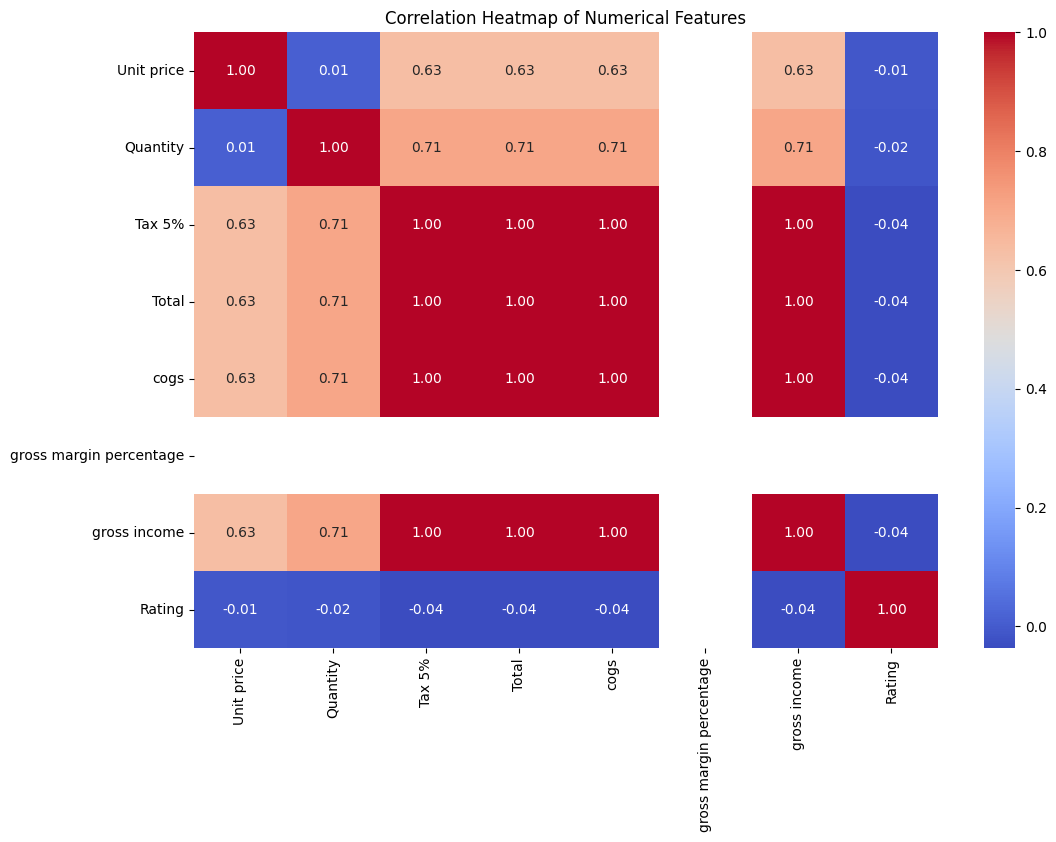

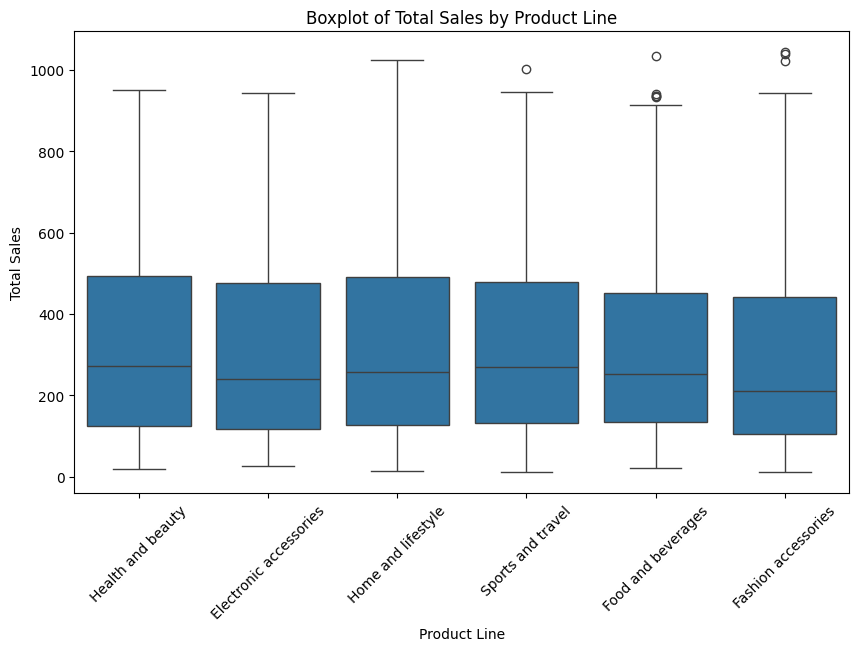

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
file_path = 'supermarket_dataset.csv'
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 1. Sales Distribution by Product Line
plt.figure(figsize=(10, 6))
sns.barplot(x='Product line', y='Total', data=df, estimator=sum, errorbar=None)
plt.title('Total Sales by Product Line')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.show()

# 2. Sales Trends Over Time
sales_trend = df.groupby(df['Date'].dt.to_period('M'))['Total'].sum()
sales_trend.plot(kind='line', figsize=(10, 6), marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.show()

# 3. Branch/City-Wise Sales
branch_sales = df.groupby('Branch')['Total'].sum()
city_sales = df.groupby('City')['Total'].sum()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
branch_sales.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Total Sales by Branch')
plt.ylabel('Total Sales')
plt.xlabel('Branch')

plt.subplot(1, 2, 2)
city_sales.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Total Sales by City')
plt.ylabel('Total Sales')
plt.xlabel('City')

plt.tight_layout()
plt.show()

# 4. Quantity vs. Total Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Total', data=df, alpha=0.7, color='orange')
plt.title('Quantity vs. Total Sales')
plt.xlabel('Quantity Sold')
plt.ylabel('Total Sales')
plt.show()

# 5. Payment Method Distribution
payment_counts = df['Payment'].value_counts()
payment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Payment Method Distribution')
plt.ylabel('')  # Remove the 'ylabel' for a cleaner chart
plt.show()

# 6. Heatmap of Correlations
numeric_df = df.select_dtypes(include=['number'])  # Selecting only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# 7. Boxplot of Total Sales by Product Line
plt.figure(figsize=(10, 6))
sns.boxplot(x='Product line', y='Total', data=df)
plt.title('Boxplot of Total Sales by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


# MODEL **TRAINING**

Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.01, 'C': 1}
Mean Squared Error: 0.001682674675833792
R-squared: 0.998065804995508


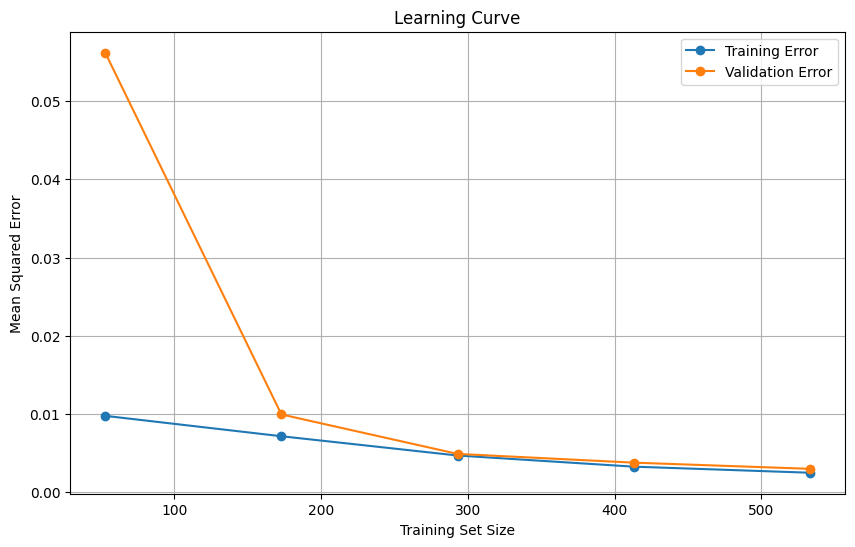

Model saved as 'svm_model.pkl'
Prediction for new data: [6.27195809]


In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv('supermarket_dataset.csv')

# Step 2: Preprocess Data
df['Date'] = pd.to_datetime(df['Date'])
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time', 'Invoice ID'], inplace=True)

# Label Encoding for Categorical Variables
categorical_columns = ['Customer type', 'Gender', 'Payment', 'City', 'Branch', 'Product line']
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Feature Engineering
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
df['LogTotal'] = np.log1p(df['Total'])

# Ensure no negative or zero values in 'Total' before log transformation
df = df[df['Total'] > 0]  # Removing rows where 'Total' is zero or negative
df['LogTotal'] = np.log1p(df['Total'])

# Prepare Features and Target
X = df[['Unit price', 'Quantity', 'Tax 5%', 'Rating', 'RevenuePerUnit']]
y = df['LogTotal']

# Step 3: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: SVM Hyperparameter Tuning
param_distributions = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVR()
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_svm = random_search.best_estimator_

# Display Best Hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Step 5: Model Evaluation
y_pred = best_svm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Step 6: Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(best_svm, X_train, y_train)

# Step 7: Save the Model
joblib.dump(best_svm, 'svm_model.pkl')
print("Model saved as 'svm_model.pkl'")

# Example: Load and Use the Saved Model
loaded_model = joblib.load('svm_model.pkl')
new_data = X_test[0:1]  # Example: Use the first row of the test set
new_prediction = loaded_model.predict(new_data)
print(f"Prediction for new data: {new_prediction}")


# **MODEL EVALUATION**

Model Performance:
Training Mean Squared Error: 0.0016
Testing Mean Squared Error: 0.0017
Training Accuracy: 99.81%
Testing Accuracy: 99.81%


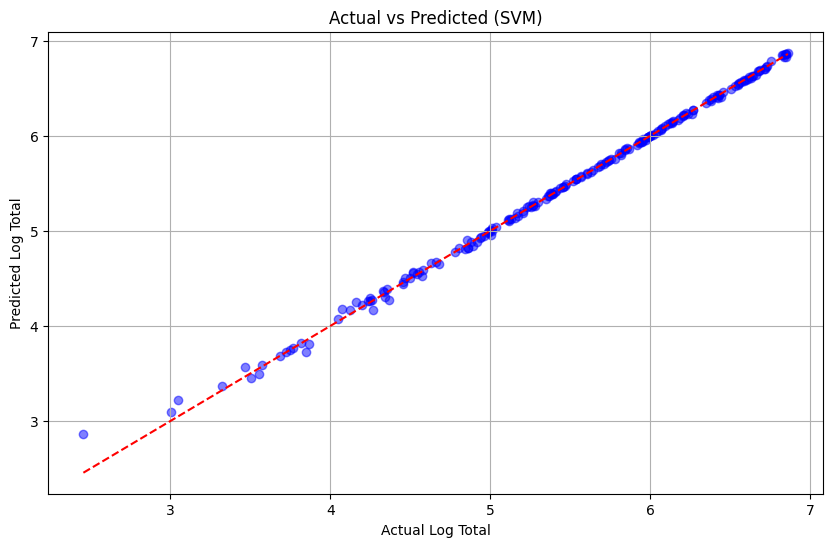

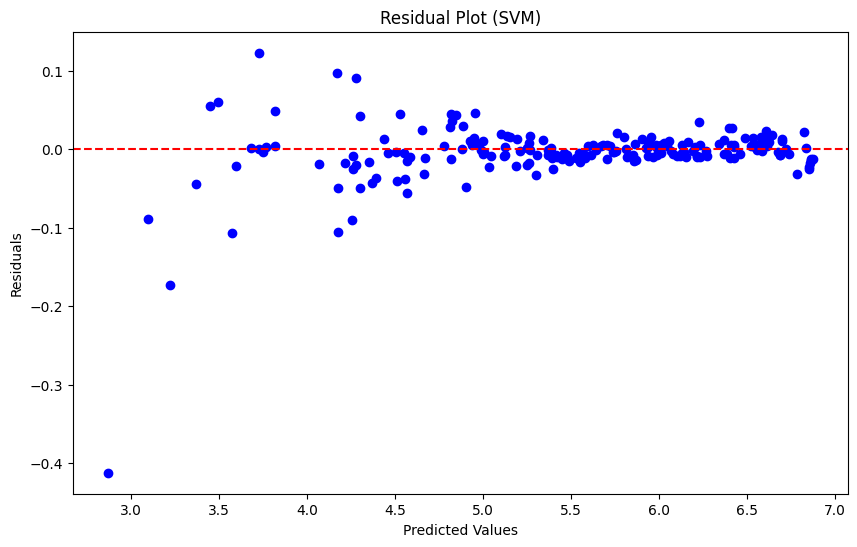

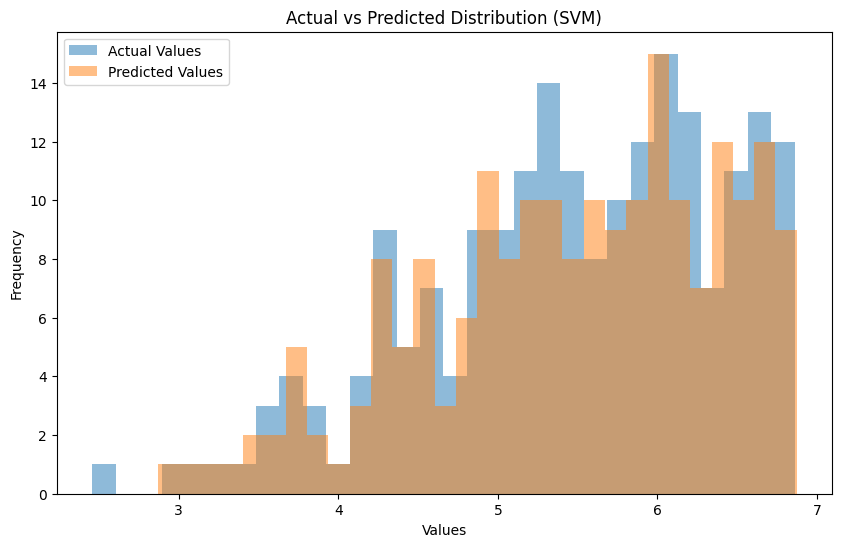

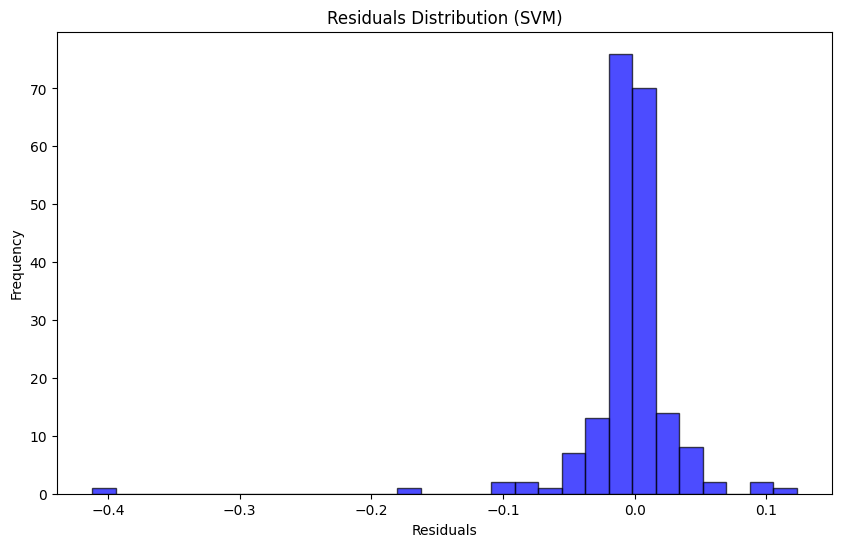

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Step 4: Model Evaluation for SVM
# Predictions for Training and Testing Data
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

# Calculate Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred) * 100  # Convert R² to percentage
test_r2 = r2_score(y_test, y_test_pred) * 100  # Convert R² to percentage

# Display Results
print("Model Performance:")
print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Testing Mean Squared Error: {test_mse:.4f}")
print(f"Training Accuracy: {train_r2:.2f}%")
print(f"Testing Accuracy: {test_r2:.2f}%")

# Performance Analysis

# Plot the Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted (SVM)")
plt.xlabel("Actual Log Total")
plt.ylabel("Predicted Log Total")
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (SVM)')
plt.show()

# Actual vs Predicted Distribution
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Actual Values')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='Predicted Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Distribution (SVM)')
plt.legend()
plt.show()

# Residuals Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution (SVM)')
plt.show()
